In [2]:
import librosa
import numpy as np
import os

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# setting up the data directory
DATA_DIR="cats_dogs/"

# setting up path for train and test data
train_dir=DATA_DIR+"/train"
test_dir=DATA_DIR+"/test"

In [26]:
class Sound:
    def __init__(self, filePath, cat, spec = None, melSpec = None):
        self.filePath = filePath
        self.cat = cat
        self.spec = spec 
        self.melSpec = melSpec

    def __str__(self):
        return f"Sound(filePath={self.filePath}, cat={self.cat}, spec={self.spec}, melSpec={self.melSpec})"
    

In [23]:


audiofiles = []

for root, dirs, files in os.walk(train_dir, topdown=False):
   for name in files:
       isCat = name.split("_")[0] == "cat"
       audiofiles.append(Sound(os.path.join(root, name),isCat))
      
np.random.shuffle(audiofiles)

In [31]:
y, sr = librosa.load(audiofiles[0].filePath)


{'filePath': 'cats_dogs//train/dog/dog_barking_51.wav',
 'cat': False,
 'spec': None,
 'melSpec': None}

In [37]:
sumDurations  = 0
sumFiles = 0
for audiofile in audiofiles:
    y, sr = librosa.load(audiofile.filePath)
    sumDurations += librosa.get_duration(y =y, sr=sr)
    sumFiles += 1
print(sumDurations/sumFiles)
TARGETDURATION = np.ceil(sumDurations/sumFiles)
TARGETDURATION

7.201193823561168


8.0

we now know that the mean duration of an audio sample ist 7.2 seconds so we will try to normalize all audiofiles

We need to normalize the shape of our audio file so we make every sound 8 seconds long

The function below creates a mel spectogram for given audio input. The input has to be the path of the input. THe audiofile has to be a tupel with the path to the soundfile first and the class second.

In [38]:
def getMelSpecLabel(audiofile:Sound):
    y, sr = librosa.load(audiofile.filePath)
    # Passing through arguments to the Mel filters
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,
                                        fmax=8000)
    audiofile.spec = librosa.power_to_db(S, ref=np.max)

In [39]:
def plotMel(audiofile:Sound):
    fig, ax = plt.subplots()
    img = librosa.display.specshow(audiofile.spec, x_axis='time',
                            y_axis='mel', 
                            fmax=8000, ax=ax)
    if audiofile.cat:
        ax.set(title="Cat")
    else:
        ax.set(title="Dog")
    fig.colorbar(img, ax=ax, format='%+2.0f dB')

ich würde gerne die verteilung der Längen der audiodaten kennen


In [44]:
for audiofile in audiofiles:
    y, sr = librosa.load(audiofile.filePath)
    target_samples = TARGETDURATION * sr
    #if((target_samples - len(y)) <100 and target_samples - len(y)>-100):
    if (len(y) > target_samples):
        print(str(len(y)) + "|" + str(target_samples))

264600|176400.0
262395|176400.0
200068|176400.0
231525|176400.0
264600|176400.0
191374|176400.0
264600|176400.0
260190|176400.0
246960|176400.0
264600|176400.0
225415|176400.0
238140|176400.0
330715|176400.0
262395|176400.0
264600|176400.0
182314|176400.0
240345|176400.0
264600|176400.0
264600|176400.0
246960|176400.0
264600|176400.0
379265|176400.0
262395|176400.0
253575|176400.0
260190|176400.0
264600|176400.0
264600|176400.0
262395|176400.0
264600|176400.0
264600|176400.0
207270|176400.0
264600|176400.0
185220|176400.0
229247|176400.0
228149|176400.0
262395|176400.0
187161|176400.0
192894|176400.0
382347|176400.0
264600|176400.0
261926|176400.0
226276|176400.0
262395|176400.0
264600|176400.0
262395|176400.0
259430|176400.0
253575|176400.0
264600|176400.0
286762|176400.0
330750|176400.0
264600|176400.0
264600|176400.0
264600|176400.0
374811|176400.0
224381|176400.0
262395|176400.0
249165|176400.0
333609|176400.0
257985|176400.0
227115|176400.0
242550|176400.0
251370|176400.0
231525|1

[[-80.       -72.4899   -20.020742 ...  -8.629105 -13.704351 -27.535675]
 [-80.       -69.233696 -24.028097 ... -20.24665  -19.73377  -30.642973]
 [-80.       -70.93329  -29.481274 ... -26.452686 -28.088074 -35.89343 ]
 ...
 [-80.       -80.       -76.88309  ... -63.282684 -66.4725   -72.795105]
 [-80.       -80.       -79.061295 ... -70.403366 -75.95705  -75.14598 ]
 [-80.       -80.       -80.       ... -80.       -80.       -78.586205]]


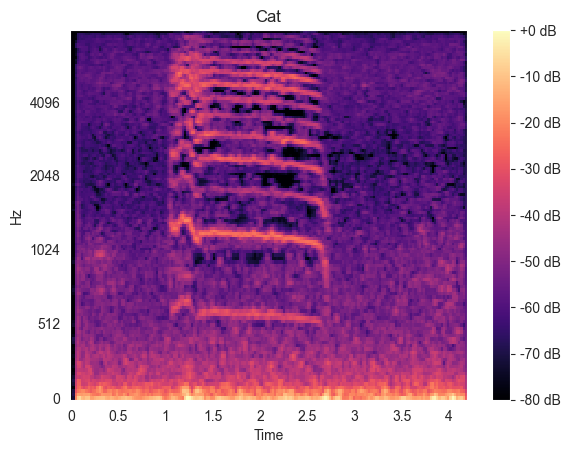

In [55]:
num = 3
processedData = getMelSpecLabel(audiofile=audiofiles[num])
print(audiofiles[num].spec)
plotMel(audiofiles[num])
#print(processedData[0].shape)

Next we have to Resize all Spectogramms to the same input shape. By converting into a mel spectogramm every Spectotramm has a heigt (first dimension) of 128, the second demension should have a length of 311

In [10]:
def pad_resize(audiofile:Sound, width:int):
    counter = 0
    if audiofile.spec.shape[1] > width:
      audiofile.spec = audiofile.spec[:, :width]
    else:
      while len(spectogram[0]) < width:
        # Create the new column
        new_column = spectogram[:, counter]
        spectogram = np.insert(spectogram, spectogram[0].size, new_column, axis=1)
        counter += 1  
    return spectogram
  

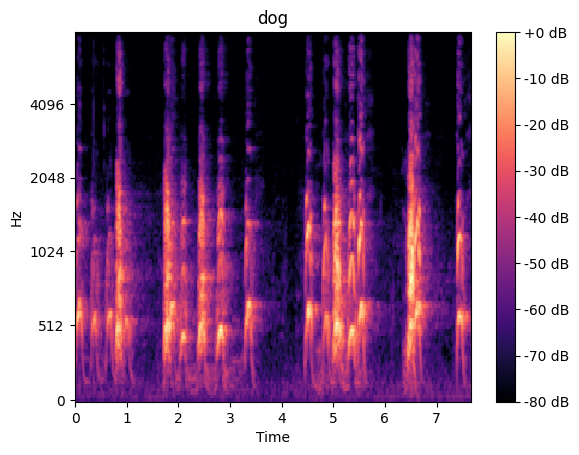

In [11]:
processedData[0].shape[0]
spec = pad_resize(processedData[0], 331)

plotMel((spec, processedData[1]))


In [12]:
sameLengthMel = []
label = []
for audiofile in audiofiles:
    processedSpectogram = getMelSpecLabel(audiofile=audiofile)
    resizedSpectogram = pad_resize(processedSpectogram[0], 331)
    sameLengthMel.append(resizedSpectogram.reshape((128,331,1)))
    label.append(processedSpectogram[1])
features = np.array(sameLengthMel)
labels =np.array(label)

In [13]:
features[0].shape

(128, 331, 1)

## The Model

In [28]:
model = keras.Sequential(layers=[
        keras.layers.InputLayer(input_shape=features[0].shape),
        keras.layers.Conv2D(16, 3, padding='same', activation=keras.activations.relu),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(32, 3, padding='same', activation=keras.activations.relu),
        keras.layers.MaxPooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation=keras.activations.relu),
        keras.layers.Dense(2, activation=keras.activations.softmax)
    ])
model.compile(optimizer=tf.keras.optimizers.legacy.Adam, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
print(model.summary())

ValueError: Could not interpret optimizer identifier: <class 'keras.src.optimizers.legacy.adam.Adam'>

In [16]:
def one_hot(array):
    unique, inverse = np.unique(labels, return_inverse=True)
    onehot = np.eye(unique.shape[0])[inverse]
    return onehot
encoded_labels = one_hot(labels)

In [27]:
# Set parameters for data splitting and training
TEST_SIZE = 0.3
BATCH_SIZE = 64
EPOCHS = 20

# Split dataset to train and test data
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=TEST_SIZE)

# Train the model
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(x=X_train, y=y_train, validation_split=TEST_SIZE, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping])

Epoch 1/20
2/2 [==============================] - 0s 148ms/step - loss: 0.6890 - accuracy: 0.5980 - val_loss: 0.6898 - val_accuracy: 0.5778
Epoch 2/20
2/2 [==============================] - 0s 136ms/step - loss: 0.6889 - accuracy: 0.5980 - val_loss: 0.6898 - val_accuracy: 0.5778
Epoch 3/20
2/2 [==============================] - 0s 139ms/step - loss: 0.6887 - accuracy: 0.5980 - val_loss: 0.6897 - val_accuracy: 0.5778
Epoch 4/20
2/2 [==============================] - 0s 133ms/step - loss: 0.6887 - accuracy: 0.5980 - val_loss: 0.6896 - val_accuracy: 0.5778
Epoch 5/20
2/2 [==============================] - 0s 138ms/step - loss: 0.6885 - accuracy: 0.5980 - val_loss: 0.6895 - val_accuracy: 0.5778
Epoch 6/20
2/2 [==============================] - 0s 148ms/step - loss: 0.6884 - accuracy: 0.5980 - val_loss: 0.6894 - val_accuracy: 0.5778
Epoch 7/20
2/2 [==============================] - 0s 147ms/step - loss: 0.6883 - accuracy: 0.5980 - val_loss: 0.6892 - val_accuracy: 0.5778
Epoch 8/20
2/2 [====

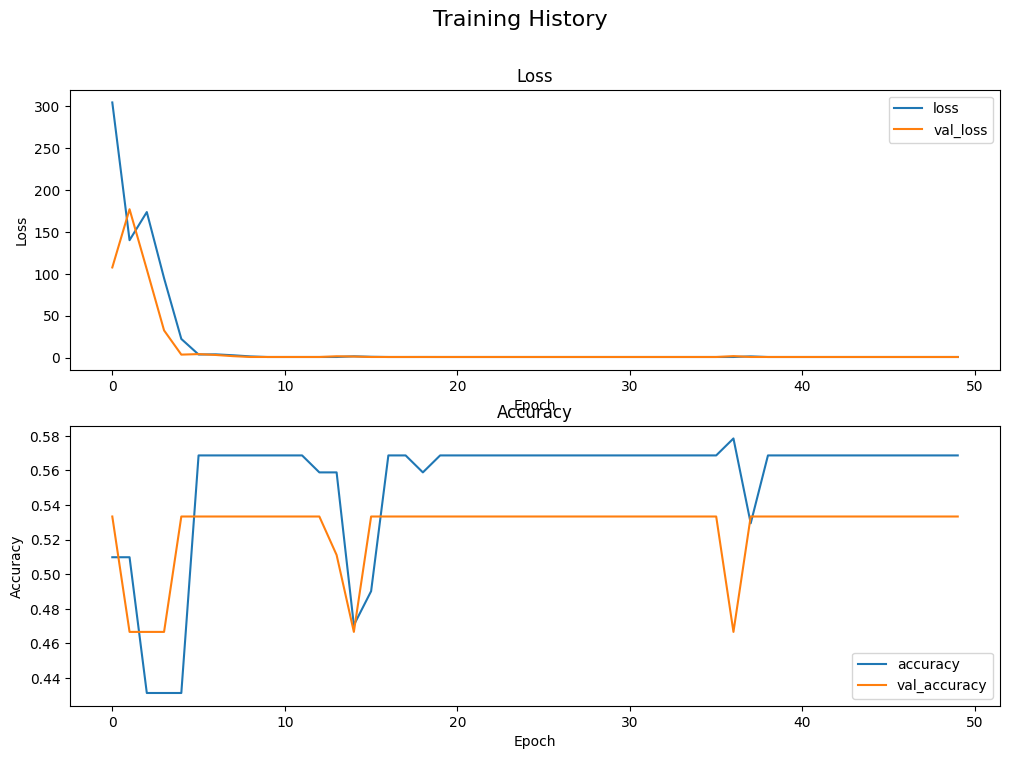

In [18]:
# Plot the training history
fig, axs = plt.subplots(2)
fig.set_size_inches(12, 8)
fig.suptitle('Training History', fontsize=16)
axs[0].plot(history.epoch, history.history['loss'], history.history['val_loss'])
axs[0].set(title='Loss', xlabel='Epoch', ylabel='Loss')
axs[0].legend(['loss', 'val_loss'])
axs[1].plot(history.epoch, history.history['accuracy'], history.history['val_accuracy'])
axs[1].set(title='Accuracy', xlabel='Epoch', ylabel='Accuracy')
axs[1].legend(['accuracy', 'val_accuracy'])
plt.show()

2/2 [==============================] - 0s 20ms/step


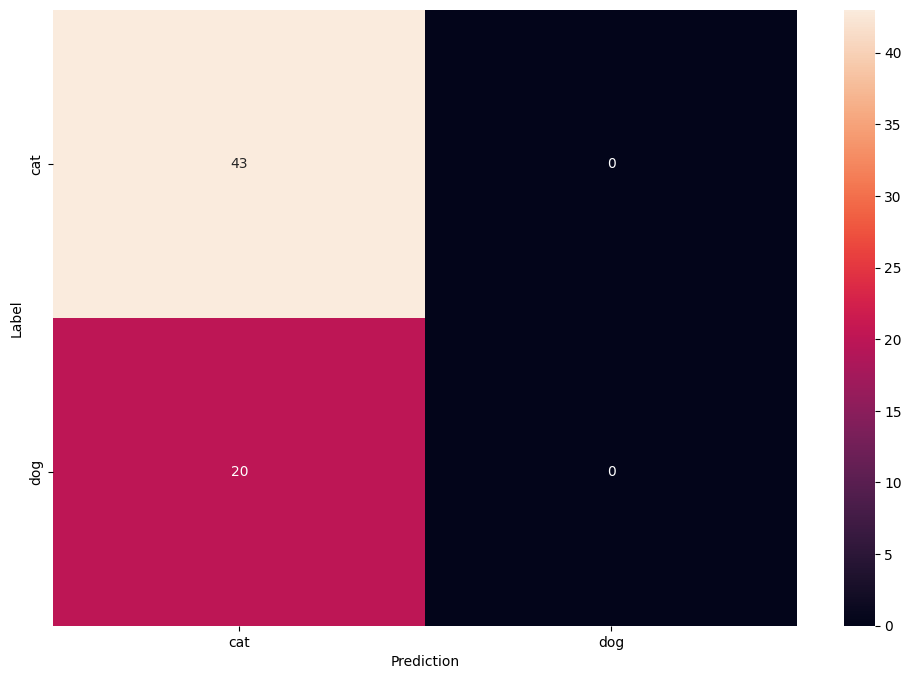

In [24]:
y_predicted = np.argmax(model.predict(x=X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
label_names = np.unique(labels)
confusion_matrix = tf.math.confusion_matrix(labels=y_true, predictions=y_predicted)
fig = plt.figure()
fig.set_size_inches(12, 8)
sns.heatmap(confusion_matrix, xticklabels=label_names, yticklabels=label_names, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [26]:
predict = getMelSpecLabel(("cats_dogs\cat_1.wav", 1))
res_predict = pad_resize(predict[0], 331)
res_predict = res_predict.reshape((1,128,331,1))
prediction = model.predict(x=res_predict)
prediction

/var/folders/ft/321k4kxs5r9cs1cshjn4m3rh0000gn/T/ipykernel_12798/4203666441.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audiofile[0])


FileNotFoundError: [Errno 2] No such file or directory: 'cats_dogs\\cat_1.wav'

In [ ]:
predict = getMelSpecLabel(("cats_dogs\dog_barking_11.wav", 1))
res_predict = pad_resize(predict[0], 331)
res_predict = res_predict.reshape((1,128,331,1))
model.predict(x=res_predict)